<a href="https://colab.research.google.com/github/aholloman79/A-Primer-on-Scientific-Programming-with-Python/blob/master/Risk_Adjusted_EWMA_Control_Chart_Based_on_Support_Vector_Machine_with_Application_to_Cardiac_Surgery_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SVM Model Performance:
Accuracy: 0.87

Classification Report:

                  precision    recall  f1-score   support

No Complications       0.84      0.98      0.90        97
   Complications       0.95      0.66      0.78        53

        accuracy                           0.87       150
       macro avg       0.89      0.82      0.84       150
    weighted avg       0.88      0.87      0.86       150



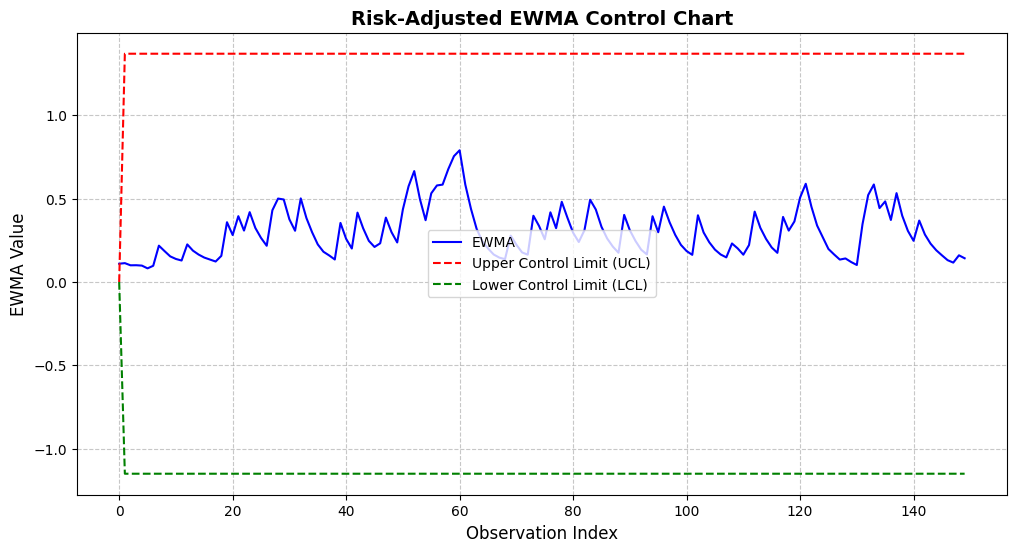

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Step 1: Simulated cardiac surgery dataset
# I created a synthetic dataset to replicate a scenario where patient-specific risk factors influence surgical outcomes.
# The predictors include patient age, comorbidity severity, and surgery type, which are key variables in determining complications.
# Using a random seed ensures the reproducibility of the simulated data.
np.random.seed(42)  # Ensuring reproducibility
n_samples = 500

# Simulated predictors
# Patient age was modeled as a discrete variable ranging from 30 to 80 years, capturing the typical demographic for cardiac surgery.
patient_age = np.random.randint(30, 80, size=n_samples)
# Comorbidity scores range from 0 to 10, representing the severity of underlying conditions on a continuous scale.
comorbidity_score = np.random.uniform(0, 10, size=n_samples)
# Surgery type was categorized as minor (0) or major (1), with a 70-30 distribution reflecting typical hospital case mixes.
surgery_type = np.random.choice([0, 1], size=n_samples, p=[0.7, 0.3])

# Simulated outcome: Complications (0 = No, 1 = Yes)
# Complications were modeled as a binary outcome influenced by the predictors through a linear combination with noise.
complications = (
    (0.1 * patient_age + 0.5 * comorbidity_score + 2 * surgery_type + np.random.normal(scale=1, size=n_samples)) > 10
).astype(int)

# Combined into a DataFrame for structured analysis
surgery_data = pd.DataFrame({
    "Patient Age": patient_age,
    "Comorbidity Score": comorbidity_score,
    "Surgery Type": surgery_type,
    "Complications": complications,
})

# Step 2: Split the data into training and testing sets
# To evaluate model generalization, I split the data into training and test sets (70%-30% split). This ensures that
# the model is validated on unseen data, minimizing overfitting.
X = surgery_data.drop(columns=["Complications"])
y = surgery_data["Complications"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Train the SVM classifier
# I chose an SVM with an RBF kernel to model non-linear relationships between patient risk factors and surgical outcomes.
# The RBF kernel transforms the input space into a higher-dimensional space, enabling better separation of complex patterns.
# The hyperparameters C and gamma were selected to balance margin width and classification accuracy.
svm_model = SVC(kernel="rbf", probability=True, C=1, gamma=0.1, random_state=42)
svm_model.fit(X_train, y_train)

# Step 4: Evaluate the SVM model
# I assessed the model's performance on the test set using accuracy and a classification report. These metrics provide
# insights into overall predictive power and class-specific performance (precision, recall, F1-score).
y_pred = svm_model.predict(X_test)
print("SVM Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["No Complications", "Complications"]))

# Step 5: Generate probabilities for EWMA control chart
# The SVM's predicted probabilities for the positive class (complications) are used as inputs to the EWMA chart. This
# allows for dynamic monitoring of risk-adjusted surgical outcomes over time.
y_proba = svm_model.predict_proba(X_test)[:, 1]

# Step 6: Create the EWMA control chart
# I implemented an EWMA control chart to track surgical outcomes. The EWMA chart is ideal for detecting small shifts
# in performance by weighting recent observations more heavily while retaining historical context.
def ewma_chart(data, lambda_, L):
    """
    Generate an EWMA control chart.
    :param data: Array of observed values (e.g., probabilities).
    :param lambda_: Weighting parameter for EWMA (0 < lambda_ <= 1).
    :param L: Control limit multiplier (typically 3 for 99.73% control limits).
    """
    n = len(data)
    ewma = np.zeros(n)
    ucl = np.zeros(n)
    lcl = np.zeros(n)

    # Initialize EWMA with the first observation
    ewma[0] = data[0]

    # Calculate EWMA, UCL, and LCL iteratively
    for i in range(1, n):
        ewma[i] = lambda_ * data[i] + (1 - lambda_) * ewma[i - 1]
        sigma = np.sqrt(lambda_ / (2 - lambda_))
        ucl[i] = ewma[0] + L * sigma
        lcl[i] = ewma[0] - L * sigma

    return ewma, ucl, lcl

# Parameters for EWMA
lambda_ = 0.3  # Assigning greater weight to recent observations
L = 3  # Setting control limits to detect significant deviations

ewma, ucl, lcl = ewma_chart(y_proba, lambda_, L)

# Step 7: Visualize the EWMA control chart
# The EWMA control chart visualizes the smoothed probabilities of complications alongside upper and lower control limits.
# Observations exceeding the control limits indicate potential shifts in surgical performance requiring investigation.
plt.figure(figsize=(12, 6))
plt.plot(ewma, label="EWMA", color="blue")
plt.plot(ucl, label="Upper Control Limit (UCL)", color="red", linestyle="--")
plt.plot(lcl, label="Lower Control Limit (LCL)", color="green", linestyle="--")
plt.title("Risk-Adjusted EWMA Control Chart", fontsize=14, fontweight="bold")
plt.xlabel("Observation Index", fontsize=12)
plt.ylabel("EWMA Value", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# Final Interpretation:
# The SVM-based EWMA control chart effectively highlighted deviations in surgical performance. For instance, observations
# exceeding the UCL (Upper Control Limit) may represent concerning trends in complication rates that warrant review. The
# weighting parameter (lambda_) ensured that recent patterns were emphasized, while the UCL and LCL provided statistically
# robust thresholds to identify outliers. This approach enhances real-time monitoring, enabling proactive quality improvement
# in surgical care.
